In [11]:
from pathlib import Path
from statistics import geometric_mean
import json
import matplotlib.pyplot as plt
from collections import defaultdict

In [12]:
class SimStats:
    def __init__(self, instrs, cycles, hits, misses):
        self.hits = hits
        self.misses = misses
        self.ipc = float(instrs) / cycles

In [13]:
CACHE_REPLACEMENT = ["lru", "lfu", "mru"]

In [14]:
cur_dir = Path.cwd() / "results"

stat_dirs = [cur_dir / pred for pred in CACHE_REPLACEMENT]
traces_stats = dict()
traces_name = list()

for stat_it in stat_dirs:
    policy_name = str(stat_it).split('/')[-1]
    traces_stats.update({policy_name: {}})

    for filename in stat_it.iterdir():
        if filename.suffix != ".json":
            continue
        #
        with open(filename) as f:
            data = json.load(f)[0]["sim"]

        instrs = data["cores"][0]["instructions"]
        cycles = data["cores"][0]["cycles"]
        l2c = data["cpu0_L2C"]
        #
        misses=sum(map(lambda v: v["miss"][0] if isinstance(v, dict) else 0,
                            l2c.values()))
        #
        hits=sum(map(lambda v: v["hit"][0] if isinstance(v, dict) else 0,
                            l2c.values()))
        #
        trace_name = str(filename).split('/')[-1]
        if trace_name not in traces_name:
            traces_name.append(trace_name)
        #
        traces_stats[policy_name].update(
            {trace_name: SimStats(instrs=instrs, cycles=cycles, hits=hits, misses=misses)})

In [26]:
def get_plot(data, title, xticks, total_width = 0.8, single_width = 1.0):

    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(9)
    bars_len = len(data)
    bar_width = total_width / bars_len
    bars = list()
    #
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - bars_len / 2) * bar_width + bar_width * 1.5
        #
        for x, y in enumerate(values):
            bar = ax.bar(
                x + x_offset,
                y,
                width=bar_width * single_width,
                color=colors[i % len(colors)],
            )
        #
        bars.append(bar[0])
    #
    plt.xticks([r + bar_width for r in range(len(xticks))],
               xticks, rotation=90)
    #
    ax.legend(bars, data.keys())
    plt.title(title)

In [27]:
HIT_RATE = dict()
IPC_STATS = dict()

for pname in traces_stats:
    HIT_RATE[pname] = list(dict())
    IPC_STATS[pname] = list(dict())

    for filename in traces_stats[pname]:
        HIT_RATE[pname].append(traces_stats[pname][filename].hits /
                               (traces_stats[pname][filename].hits + traces_stats[pname][filename].misses))
        IPC_STATS[pname].append(traces_stats[pname][filename].ipc)

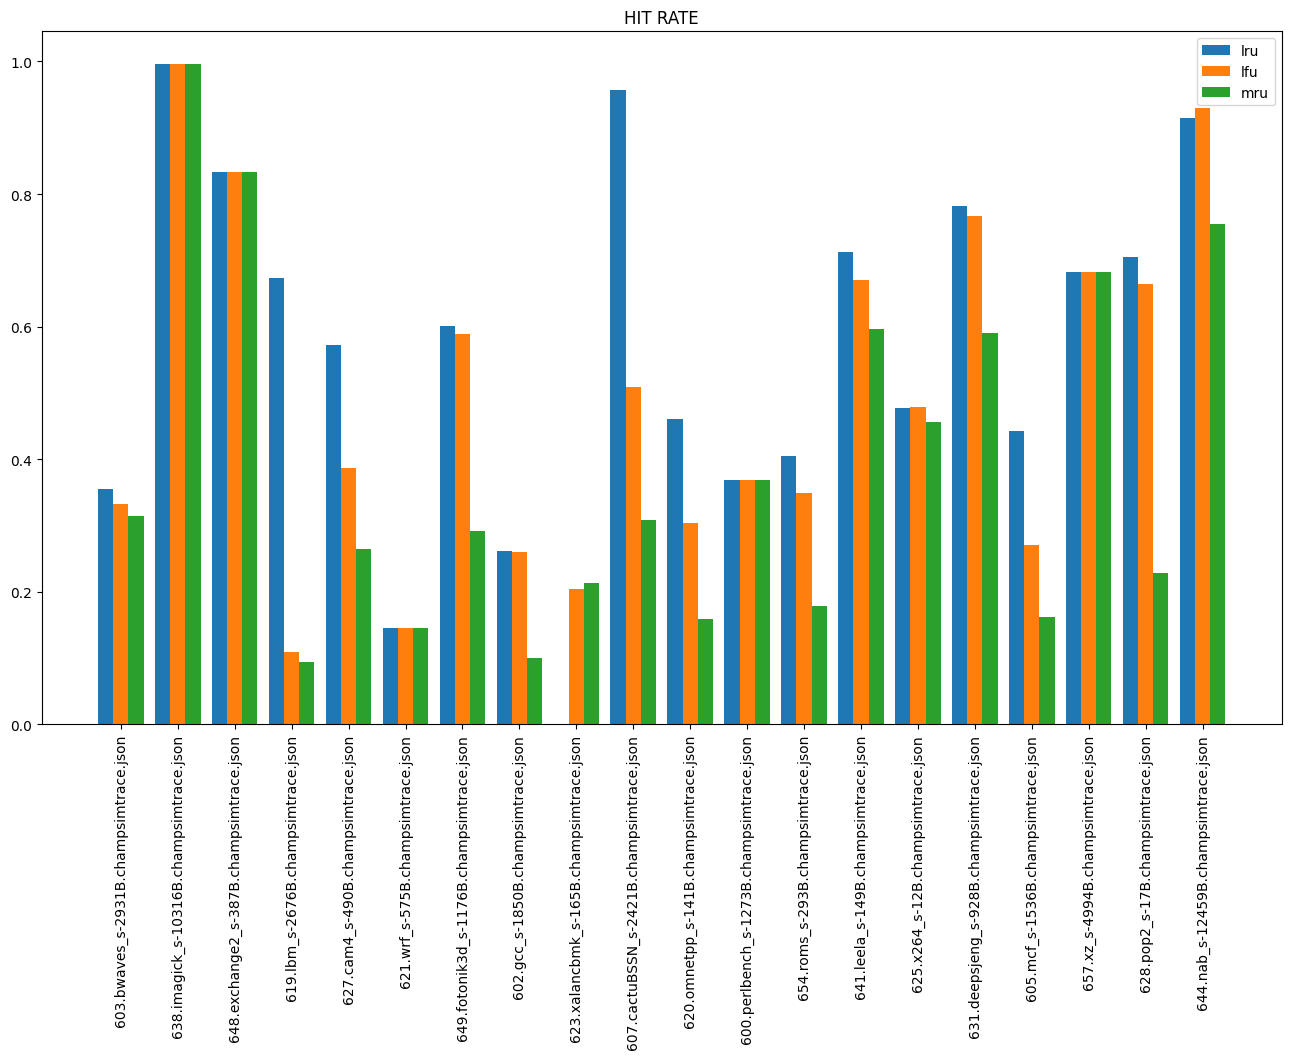

In [28]:
get_plot(data=HIT_RATE, title="HIT RATE", xticks=traces_name)

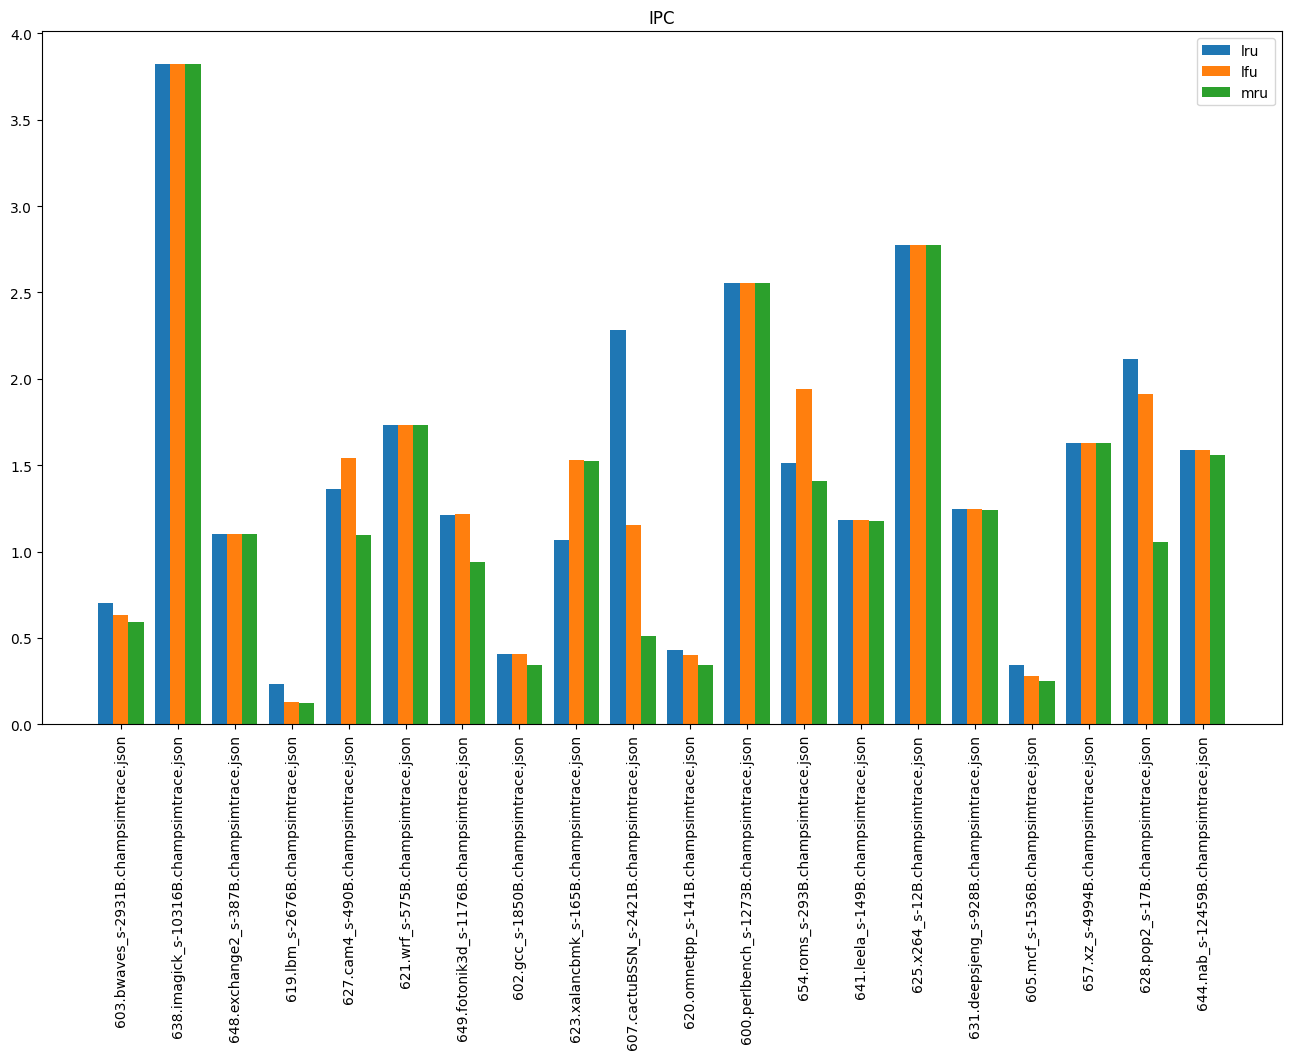

In [29]:
get_plot(data=IPC_STATS, title="IPC", xticks=traces_name)

In [31]:
def get_gmean_plot(data: dict, title, color='b'):
    assert isinstance(data, dict)
    #
    gmean = list()

    for name in data.keys():
        gmean.append(geometric_mean(data[name]))

    plt.bar(data.keys(), gmean, color=color)
    plt.title(title)
    plt.show()

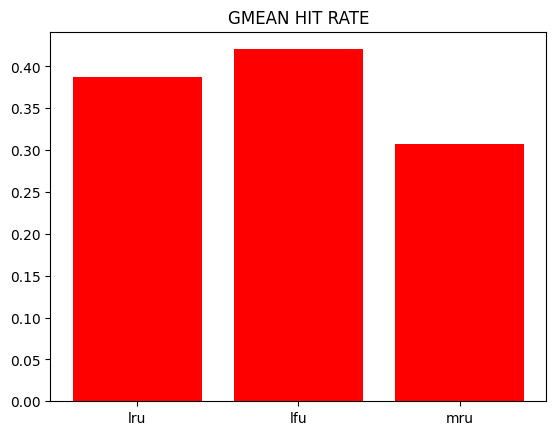

In [32]:
get_gmean_plot(data=HIT_RATE, title="GMEAN HIT RATE", color='r')

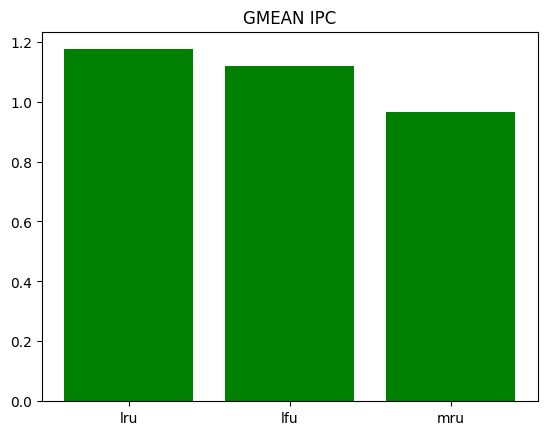

In [33]:
get_gmean_plot(data=IPC_STATS, title="GMEAN IPC", color='g')